In [4]:
import os.path
import pandas as pd
from scipy.io import arff


file_name = '/kaggle/input/eye-state-classification-eeg-dataset/EEG Eye State.arff'

data, meta = arff.loadarff(file_name)
data = pd.DataFrame(data)

# 将最后一列转化成整数
data["eyeDetection"] = data["eyeDetection"].astype('int')

# 输出一下数据，并检查是否成功读取
data.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832,0.448798
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043,0.497388
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000,1.000000


In [5]:
# 检测数据中的异常值，来提升最终分类的效果

import numpy as np
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


# 设置可重复结果的随机种子
rng = np.random.RandomState(42)

# 在数据分析中，常将0.5%的数据视为异常值，是人为地且保守的，可以进行调整
factorContaminacion = 0.5/100 

cOneClassSVM = svm.OneClassSVM(nu=1 - factorContaminacion, kernel="rbf", gamma=0.1)
cIsolationForest = IsolationForest(contamination=factorContaminacion, random_state=rng, n_jobs=-1)
cLocalOutlierFactor = LocalOutlierFactor(n_neighbors=35, contamination=factorContaminacion, n_jobs=-1)

# 调整模型并为每个方法计算每个数据的标签。需要几分钟
cOneClassSVM.fit(X=data)
cIsolationForest.fit(X=data)
esOutlier = np.column_stack((cOneClassSVM.predict(X=data), cIsolationForest.predict(X=data), cLocalOutlierFactor.fit_predict(X=data))) == -1
esOutlier = esOutlier.sum(axis=1) >= 2

# 统计一下一共检测到了多少异常值
esOutlier.sum()

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


20

[[<Axes: title={'center': 'AF3'}> <Axes: title={'center': 'F7'}>
  <Axes: title={'center': 'F3'}> <Axes: title={'center': 'FC5'}>
  <Axes: title={'center': 'T7'}> <Axes: title={'center': 'P7'}>
  <Axes: title={'center': 'O1'}>]
 [<Axes: title={'center': 'O2'}> <Axes: title={'center': 'P8'}>
  <Axes: title={'center': 'T8'}> <Axes: title={'center': 'FC6'}>
  <Axes: title={'center': 'F4'}> <Axes: title={'center': 'F8'}>
  <Axes: title={'center': 'AF4'}>]
 [<Axes: title={'center': 'eyeDetection'}> <Axes: > <Axes: > <Axes: >
  <Axes: > <Axes: > <Axes: >]]


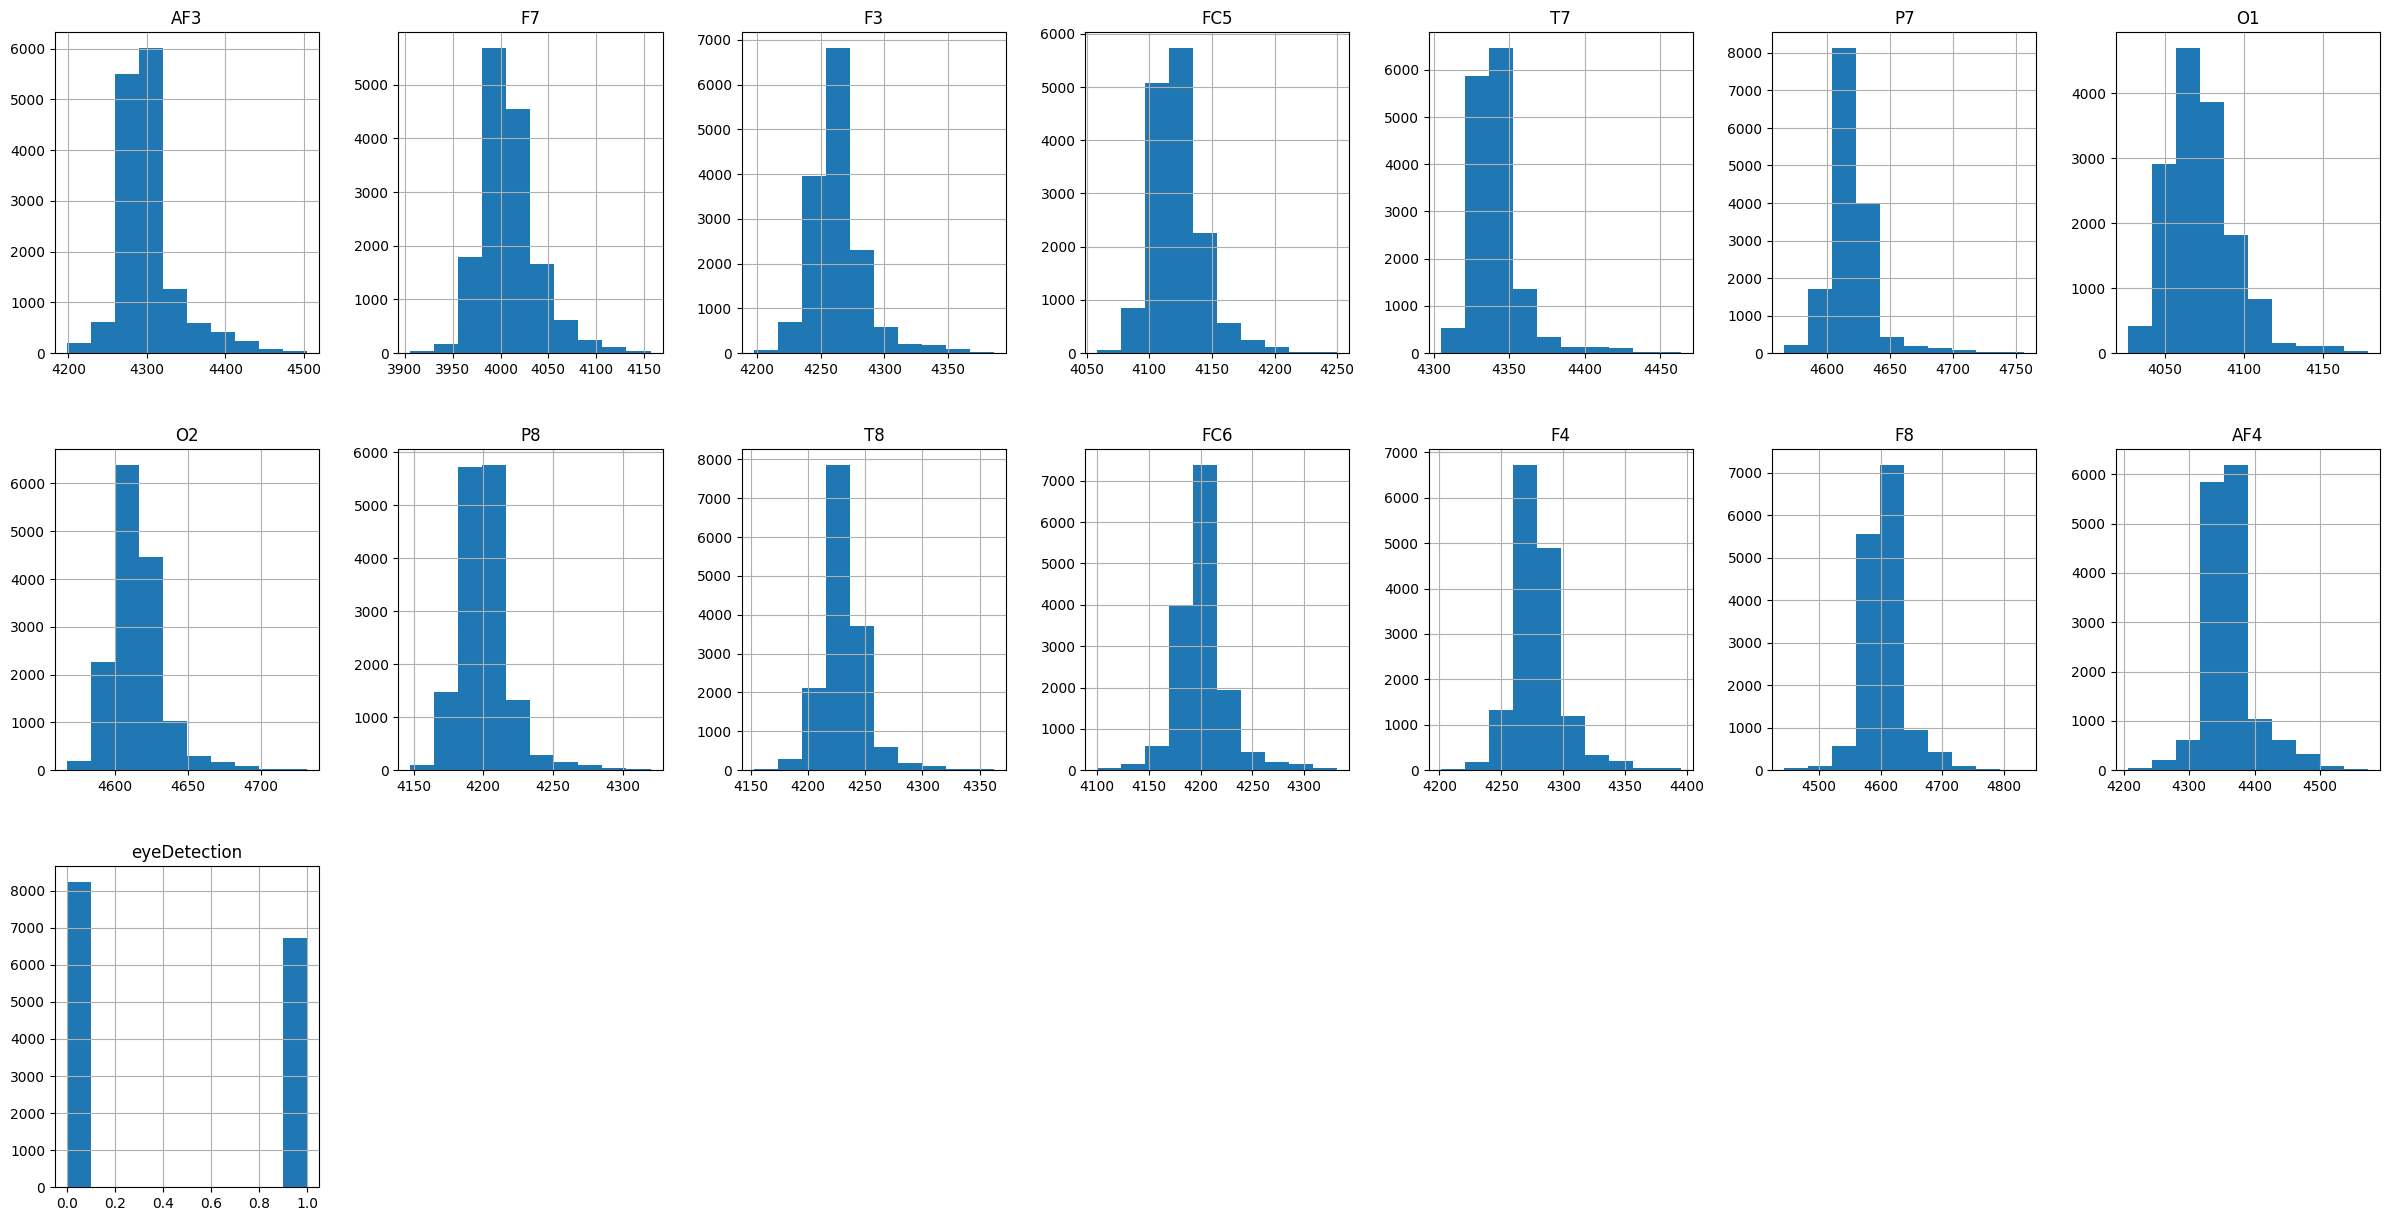

In [6]:
# 去掉上面检测到的异常值，结果的效果会更好。此外，受影响变量的偏差明显减少。
validData = data[~esOutlier]

# 然后可视化一下数据，绘制柱状图
import matplotlib.pyplot as plt
%matplotlib inline

print(validData.hist(layout=(3, 7), figsize=(30, 15)))

In [7]:
from sklearn.model_selection import train_test_split

# 标签是我们想要预测的值
labels = np.array(validData['eyeDetection'])

# 去掉特性上的标签，就是 axis=1 所指代的列
features= validData.drop('eyeDetection', axis = 1)

# 将特征名保存，便于后续使用
feature_list = list(features.columns)

# 格式转换成 numpy array
features = np.array(features)

# 划分数据集
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 1/3, random_state = rng)

In [8]:
from sklearn import preprocessing

# 使用数据的平均值和范围来对数据进行缩放
scaler = preprocessing.StandardScaler().fit(train_features)
sc_train_features = scaler.transform(train_features)
sc_test_features = scaler.transform(test_features)

In [9]:
import tensorflow as tf
from tensorflow import keras

# 初始化，从零开始
tf.keras.backend.clear_session()

# 具体定义模型
model = keras.Sequential()

model.add(keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(14,)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.compile(optimizer='SGD',
           loss='binary_crossentropy',
           metrics=['accuracy'])

2024-04-11 03:24:42.235360: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 03:24:42.235498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 03:24:42.402534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# 模型训练，500次迭代让它可以进化，但同时加了一个早停的回调，如果损失函数没有改善就停止。
# 将verbose设置为0，避免输出太多文字，如果想要查看训练进度可以设置为1。

history = model.fit(sc_train_features,
                 train_labels,
                 epochs=500,
                 batch_size=128,
                 callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          min_delta=0,
                                                          patience=3,
                                                          verbose=0, mode='auto')],
                 validation_data=(sc_test_features, test_labels),
                 verbose=0)

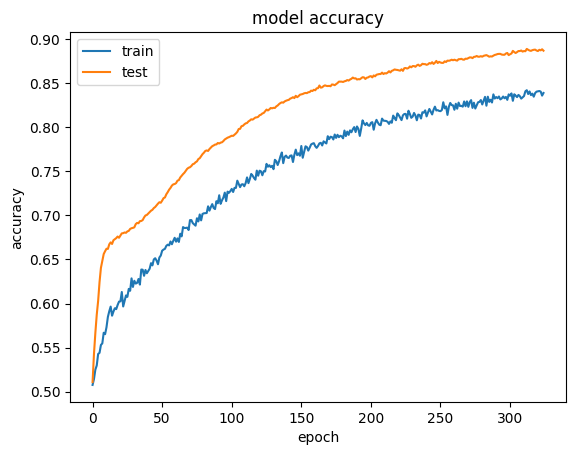

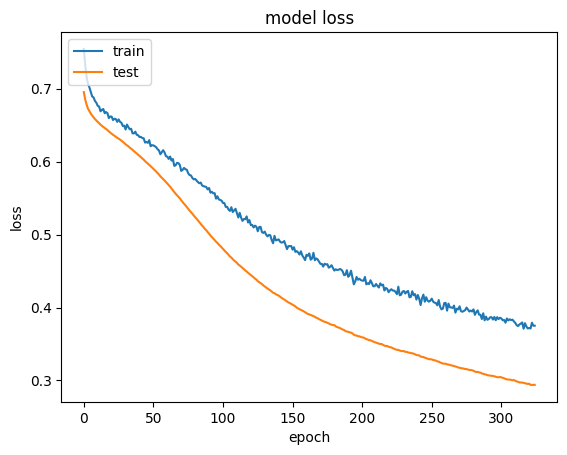

In [12]:
# 绘制准确率对比图
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 绘制损失函数对比图
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()